## Required libraries

In [ ]:
import os
import shutil
import cv2
import math
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2

from IPython.display import HTML
from base64 import b64encode

<ipython-input-1-e95167a3b609>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


## Loading Dataset

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

100% 3.58G/3.58G [03:05<00:00, 23.8MB/s]
100% 3.58G/3.58G [03:05<00:00, 20.8MB/s]


In [ ]:
! unzip /content/real-life-violence-situations-dataset.zip

Archive:  /content/real-life-violence-situations-dataset.zip
  inflating: Real Life Violence Dataset/NonViolence/NV_1.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_10.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_100.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_1000.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_101.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_102.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_103.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_104.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_105.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_106.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_107.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_108.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_109.mp4  
  inflating: Real Life Violence Dataset/NonViolence/NV_11.mp4  
  inflating: Real Life Violence 

In [ ]:
NonViolnceVideos_Dir = "/content/real life violence situations/Real Life Violence Dataset/NonViolence"
ViolnceVideos_Dir = "/content/real life violence situations/Real Life Violence Dataset/Violence"

In [ ]:
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

In [ ]:
def Play_Video(filepath):
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html = '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [ ]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

#### A Random Non-Violence video

In [ ]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

#### A Random Violence Video

In [ ]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

## Dataset Analysis

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16

In [ ]:
DATASET_DIR = "/content/real life violence situations/Real Life Violence Dataset"

In [ ]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [ ]:
file_paths =[]
for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in tqdm(files_list):
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            file_paths.append(video_file_path)

Extracting Data of Class: NonViolence


100%|██████████| 1000/1000 [00:00<00:00, 205522.54it/s]


Extracting Data of Class: Violence


100%|██████████| 1000/1000 [00:00<00:00, 271810.25it/s]


In [ ]:
num_frames=[]
for path in tqdm(file_paths):
  video_reader = cv2.VideoCapture(path)
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  num_frames.append(video_frames_count)

100%|██████████| 2000/2000 [00:06<00:00, 307.93it/s]


In [ ]:
num_frames.sort()
print("First 10 and last 10 according to the number of Frames for all videos")
print(num_frames[:10] + num_frames[-10:])

First 10 and last 10 according to the number of Frames for all videos
[29, 36, 50, 55, 55, 55, 55, 55, 55, 55, 210, 210, 213, 222, 222, 228, 283, 4109, 5397, 11272]


In [ ]:
print("Average number of Frames:",np.mean(num_frames[:-3]))

Average number of Frames: 133.49574361542312


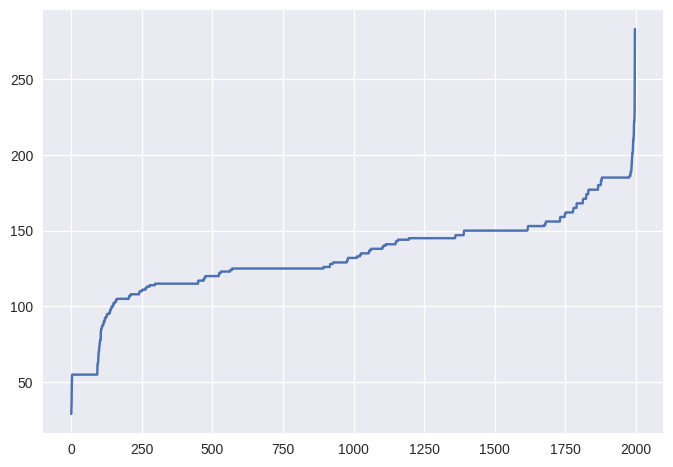

In [ ]:
plt.plot(num_frames[:-3])
plt.show()

#### Most of the videos have less than 200 frames

## Preparing Data for training
#### Breaking into frames and saving as features array

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in tqdm(files_list):
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [ ]:
import shutil
source = '/content/features.npy'
dest = '/content/drive/MyDrive/Temp'

In [ ]:
shutil.copy(source,dest)

'/content/drive/MyDrive/Temp/video_files_paths.npy'

In [ ]:
features.shape

(2000, 16, 64, 64, 3)

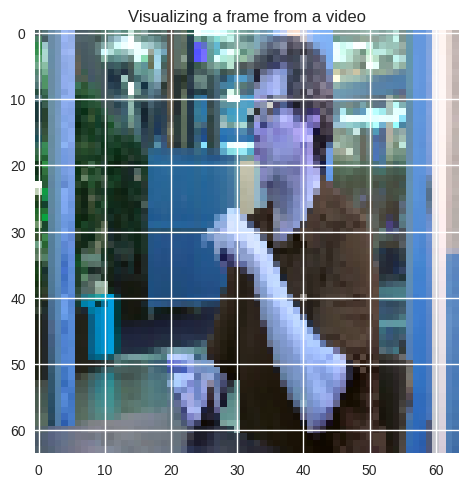

In [ ]:
frame = features[21][0]
plt.title("Visualizing a frame from a video")
plt.imshow(frame)

In [ ]:
features, labels, video_files_paths = np.load("/content/drive/MyDrive/Temp/features.npy"), np.load("/content/drive/MyDrive/Temp/labels.npy"), np.load("/content/drive/MyDrive/Temp/video_files_paths.npy")

In [ ]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1,
                                                                            shuffle=True, random_state=42)

In [ ]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


## MoBiLstm Model

Loading the MobileNetV2 model with existing weights from imagenet and freezing all the layers except last 40 as non trainable

In [ ]:
mobilenet = MobileNetV2(include_top=False, weights="imagenet")
mobilenet.trainable = True

In [ ]:
for layer in mobilenet.layers[:-40]:
    layer.trainable = False

Using the mobile net model for extracting features and later implementing Bi-Directional LSTM which uses those features for sequential modelling

In [ ]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

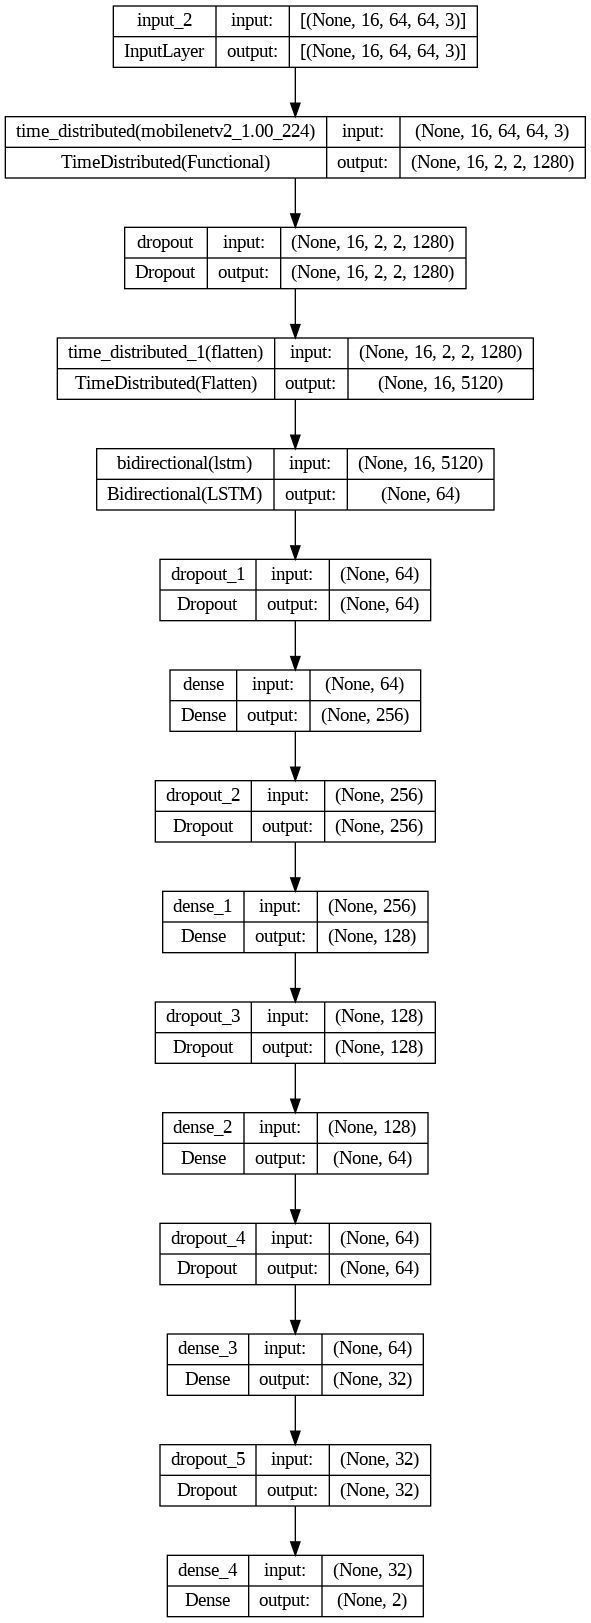

In [ ]:
MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file='MobBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

In [ ]:
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
MobBiLSTM_model_history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=30, batch_size=8,
                                             shuffle=True, validation_split=0.2,
                                             callbacks=[early_stopping_callback, reduce_lr])

Epoch 1/30
180/180 [==============================] - 36s 82ms/step - loss: 0.6553 - accuracy: 0.6104 - val_loss: 0.6081 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 2/30
180/180 [==============================] - 12s 65ms/step - loss: 0.4680 - accuracy: 0.8000 - val_loss: 0.4820 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 3/30
180/180 [==============================] - 11s 63ms/step - loss: 0.3542 - accuracy: 0.8667 - val_loss: 0.4839 - val_accuracy: 0.8250 - lr: 0.0010
Epoch 4/30
180/180 [==============================] - 11s 62ms/step - loss: 0.3824 - accuracy: 0.8451 - val_loss: 0.4441 - val_accuracy: 0.8222 - lr: 0.0010
Epoch 5/30
180/180 [==============================] - 11s 63ms/step - loss: 0.2872 - accuracy: 0.8924 - val_loss: 0.3572 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/30
180/180 [==============================] - 11s 62ms/step - loss: 0.2914 - accuracy: 0.8931 - val_loss: 0.3700 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 7/30
180/180 [==============================] - 11s 

In [ ]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

7/7 [==============================] - 4s 59ms/step - loss: 0.2980 - accuracy: 0.9500


In [ ]:
MoBiLSTM_model.save("/content/drive/MyDrive/Temp/Violence_Detection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

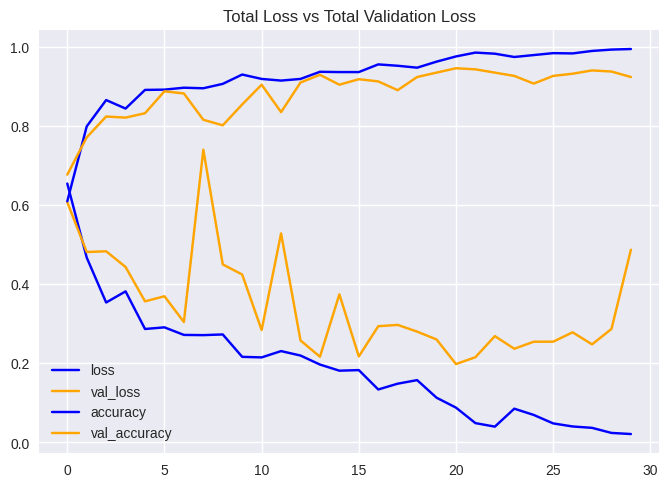

In [ ]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [ ]:
labels_predict = MoBiLSTM_model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

7/7 [==============================] - 3s 68ms/step


In [ ]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.95


In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal, labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.93      0.97      0.95        99
           1       0.97      0.93      0.95       101

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

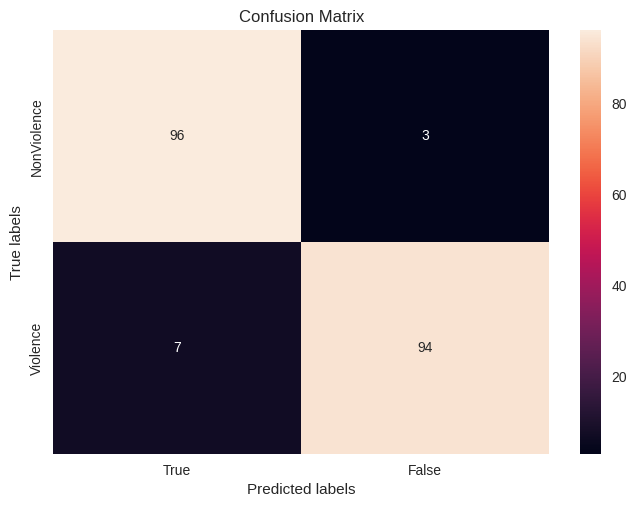

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

## CNN Model

Implementing a 3D CNN model

In [ ]:
from keras.layers import Conv3D, MaxPooling3D, Flatten

def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    # Replacing TimeDistributed(mobilenet) with 3D convolutional layers
    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    # Add Dropout layers for regularization
    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

In [ ]:
CNN_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 62, 62, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 31, 31, 64)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 29, 29, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 14, 14, 128)    0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

In [ ]:
CNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
CNN_model_history = CNN_model.fit(x=features_train, y=labels_train, epochs=40, batch_size=8,
                                             shuffle=True, validation_split=0.2,
                                             callbacks=[early_stopping_callback, reduce_lr])

Epoch 1/40
180/180 [==============================] - 18s 56ms/step - loss: 0.7029 - accuracy: 0.4965 - val_loss: 0.6528 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 2/40
180/180 [==============================] - 9s 49ms/step - loss: 0.6564 - accuracy: 0.5243 - val_loss: 0.5794 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 3/40
180/180 [==============================] - 9s 49ms/step - loss: 0.6421 - accuracy: 0.5660 - val_loss: 0.6065 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 4/40
180/180 [==============================] - 9s 50ms/step - loss: 0.5995 - accuracy: 0.6632 - val_loss: 0.5852 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 5/40
180/180 [==============================] - 9s 48ms/step - loss: 0.5528 - accuracy: 0.7076 - val_loss: 0.5524 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 6/40
180/180 [==============================] - 9s 49ms/step - loss: 0.4759 - accuracy: 0.7799 - val_loss: 0.4993 - val_accuracy: 0.7806 - lr: 0.0010
Epoch 7/40
180/180 [==============================] - 9s 48ms/s

In [ ]:
model_evaluation_history = CNN_model.evaluate(features_test, labels_test)

7/7 [==============================] - 1s 53ms/step - loss: 1.6063 - accuracy: 0.8150


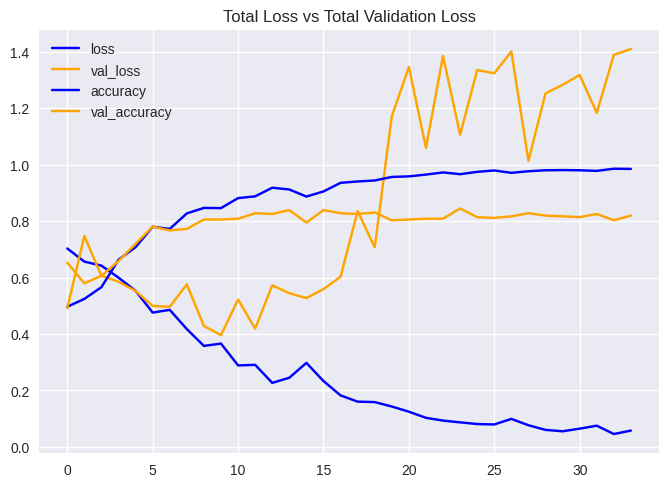

In [ ]:
plot_metric(CNN_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metric(CNN_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [ ]:
labels_predict = CNN_model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

7/7 [==============================] - 1s 65ms/step


In [ ]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.815


In [ ]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal, labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.80      0.83      0.82        99
           1       0.83      0.80      0.81       101

    accuracy                           0.81       200
   macro avg       0.82      0.82      0.81       200
weighted avg       0.82      0.81      0.81       200



[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

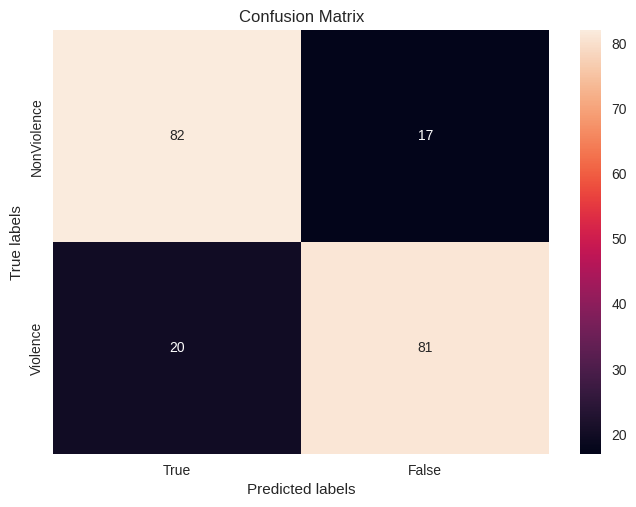

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

## Grad-CAM

Using Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize the regions of interest in video frames that contribute most to the classification decision

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Bidirectional, Dense, Dropout, Flatten
from tensorflow.keras.applications import MobileNetV2

input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
mobilenet = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
lstm_fw = LSTM(units=32, return_sequences=True)
lstm_bw = LSTM(units=32, go_backwards=True, return_sequences=True)
model = create_model()
grad_cam_model = Sequential([Input(shape=input_shape), TimeDistributed(mobilenet), Dropout(0.25), TimeDistributed(Flatten()), Bidirectional(lstm_fw, backward_layer=lstm_bw)])
grad_cam_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 14, 62, 62, 64)    5248      
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 7, 31, 31, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 29, 29, 128)    221312    
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 2, 14, 14, 128)    0         
 g3D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dropout_5 (Dropout)         (None, 50176)            

In [ ]:
def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    for _ in range(SEQUENCE_LENGTH):
        ret, frame = cap.read()
        if not ret:
            break
        # Resize frame to match model input shape
        frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        # Normalize pixel values to [0, 1]
        frame = frame / 255.0
        frames.append(frame)
    cap.release()
    return np.array(frames)

In [ ]:
def visualize_grad_cam(video_path, model, grad_cam_model, target_class_index):
    # Load and preprocess video frames
    frames = preprocess_video(video_path)
    frames = np.expand_dims(frames, axis=0)
    # Compute Grad-CAM heatmap
    #conv_output = grad_cam_model.predict(frames)
    grad_model = Model(inputs=grad_cam_model.input, outputs=[grad_cam_model.output])
    with tf.GradientTape() as tape:
        conv_output = grad_model(frames)
        class_output = conv_output[:, target_class_index]

    # Compute gradients of the target class output with respect to the conv_output
    grads = tape.gradient(class_output, conv_output)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))


    # Compute the heatmap by multiplying each channel in the feature map by "how important this channel is" (pooled_grads)
    heatmap = tf.reduce_mean(conv_output * pooled_grads[..., tf.newaxis], axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # Resize heatmap to match the original frame size
    heatmap = cv2.resize(heatmap, (frames.shape[2], frames.shape[3]))

    # Convert heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    return heatmap


In [ ]:
def overlay_heatmap(image, heatmap, alpha=0.1):
    # Normalize the heatmap
    heatmap_normalized = heatmap / np.max(heatmap)
    heatmap_normalized = np.uint8(255 * heatmap_normalized)
    heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)  # Apply color map to the heatmap

    # Convert heatmap to same data type as image
    heatmap_colored = heatmap_colored.astype(image.dtype)

    # Overlay the heatmap on the image
    result = cv2.addWeighted(image, 1, heatmap_colored, alpha, 0)

    return result

In [ ]:
# Example:
example_video_path = '/content/real life violence situations/Real Life Violence Dataset/Violence/V_100.mp4'
target_class_index = 0
heatmap = visualize_grad_cam(example_video_path, model, grad_cam_model, target_class_index)

In [ ]:
frames= preprocess_video(example_video_path)
result = overlay_heatmap(frames[0],heatmap)

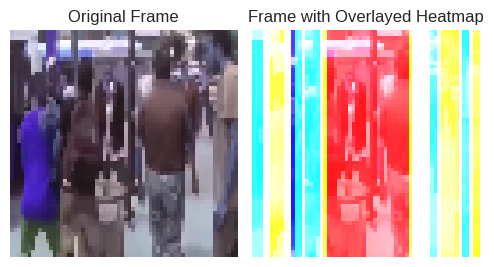

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(5, 5))

# Display the original frame in the first subplot
axs[0].imshow(frames[0])
axs[0].set_title('Original Frame')
axs[0].axis('off')

# Display the frame with overlaid heatmap in the second subplot
axs[1].imshow(result)
axs[1].set_title('Frame with Overlayed Heatmap')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
Play_Video(example_video_path)